# Uber Supply-Demand Gap Assignment

## Importing numpy and pandas libraries

In [28]:
# Import the numpy and pandas packages
import numpy as np
import pandas as pd

## Importing matplotlib and seaborn libraries

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Importing Data from CSV

In [68]:
# Read the csv file using 'read_csv'
uber_data = pd.read_csv('Uber Request Data.csv')

## Inspecting the dataframe

In [69]:
# Observing actual data in dataframe

uber_data

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp
0,619,Airport,1.0,Trip Completed,11/7/2016 11:51,11/7/2016 13:00
1,867,Airport,1.0,Trip Completed,11/7/2016 17:57,11/7/2016 18:47
2,1807,City,1.0,Trip Completed,12/7/2016 9:17,12/7/2016 9:58
3,2532,Airport,1.0,Trip Completed,12/7/2016 21:08,12/7/2016 22:03
4,3112,City,1.0,Trip Completed,13-07-2016 08:33:16,13-07-2016 09:25:47
...,...,...,...,...,...,...
6740,6745,City,NaN,No Cars Available,15-07-2016 23:49:03,NaN
6741,6752,Airport,NaN,No Cars Available,15-07-2016 23:50:05,NaN
6742,6751,City,NaN,No Cars Available,15-07-2016 23:52:06,NaN
6743,6754,City,NaN,No Cars Available,15-07-2016 23:54:39,NaN


** Inference 1:** 'Driver id' fields have decimal values however, it should be integer values

** Inference 2:** 'Request timestamp' and 'Drop timestamp' fields have dates in different formats however, it should be in uniform format for analysis. Eg. '15-07-2016 10:00:43' vs. '11/7/2016 13:08'

In [70]:
# Check the number of rows and columns in the dataframe
uber_data.shape

(6745, 6)

In [71]:
# Check the column-wise info of the dataframe
uber_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6745 entries, 0 to 6744
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Request id         6745 non-null   int64  
 1   Pickup point       6745 non-null   object 
 2   Driver id          4095 non-null   float64
 3   Status             6745 non-null   object 
 4   Request timestamp  6745 non-null   object 
 5   Drop timestamp     2831 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 316.3+ KB


** Inference 3:** 'Driver id' fields and 'Drop timestamp' have many 'NaN' values

### Summary of Inspecting the dataframe
* 'Driver id' fields have decimal values however, it should be integer values
* 'Request timestamp' and 'Drop timestamp' fields have dates in different formats however, it should be in uniform format for analysis. Eg. '15-07-2016 10:00:43' vs. '11/7/2016 13:08'
* 'Driver id' fields and 'Drop timestamp' have many 'NaN' values

 ----

## Data Cleaning

### Ignoring 'Driver id' field since our analysis is focussed on aggregation of all bookings and not individual bookings

In [72]:
#uber_data = uber_data.drop(['Driver id'], axis = 1)

uber_data.head()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp
0,619,Airport,1.0,Trip Completed,11/7/2016 11:51,11/7/2016 13:00
1,867,Airport,1.0,Trip Completed,11/7/2016 17:57,11/7/2016 18:47
2,1807,City,1.0,Trip Completed,12/7/2016 9:17,12/7/2016 9:58
3,2532,Airport,1.0,Trip Completed,12/7/2016 21:08,12/7/2016 22:03
4,3112,City,1.0,Trip Completed,13-07-2016 08:33:16,13-07-2016 09:25:47


### Converting 'Request timestamp' and 'Drop timestamp' fields to uniform format

In [73]:
from datetime import datetime

# Make the date-time columns, 'Request timestamp' and 'Drop timestamp' as uniform datetime format.
def uniform_format(var):
    try:
        if var == ' ':
            return var
        elif '-' in var:
            return datetime.strptime(var, '%d-%m-%Y %H:%M:%S')
        elif '/' in var:
            return datetime.strptime(var, '%d/%m/%Y %H:%M')
    except Exception as e:
        print(e, var)

# Replacing missing values in 'Drop timestamp' by 'Request timestamp', thus 'Ride Duration' becomes 0 minutes
uber_data.loc[pd.isnull(uber_data['Drop timestamp']), ['Drop timestamp']] = uber_data['Request timestamp']

# Applying uniform datetime format on 'Request timestamp' and 'Drop timestamp' columns.
uber_data['Request timestamp'] = uber_data['Request timestamp'].apply(lambda x: uniform_format(x))
uber_data['Drop timestamp'] = uber_data['Drop timestamp'].apply(lambda x: uniform_format(x))

uber_data.head()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp
0,619,Airport,1.0,Trip Completed,2016-07-11 11:51:00,2016-07-11 13:00:00
1,867,Airport,1.0,Trip Completed,2016-07-11 17:57:00,2016-07-11 18:47:00
2,1807,City,1.0,Trip Completed,2016-07-12 09:17:00,2016-07-12 09:58:00
3,2532,Airport,1.0,Trip Completed,2016-07-12 21:08:00,2016-07-12 22:03:00
4,3112,City,1.0,Trip Completed,2016-07-13 08:33:16,2016-07-13 09:25:47


### Identifying additional data quality issues

In [74]:
# Get the column-wise Null count using 'is.null()' alongwith the 'sum()' function
uber_data.isnull().sum()

Request id              0
Pickup point            0
Driver id            2650
Status                  0
Request timestamp       0
Drop timestamp          0
dtype: int64

### Making a derived column, 'Duration'

In [75]:
uber_data['Duration'] = uber_data['Drop timestamp']-uber_data['Request timestamp']

uber_data['Duration'] = round(uber_data['Duration'].dt.total_seconds()/60,1)

In [76]:
uber_data.head()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp,Duration
0,619,Airport,1.0,Trip Completed,2016-07-11 11:51:00,2016-07-11 13:00:00,69.0
1,867,Airport,1.0,Trip Completed,2016-07-11 17:57:00,2016-07-11 18:47:00,50.0
2,1807,City,1.0,Trip Completed,2016-07-12 09:17:00,2016-07-12 09:58:00,41.0
3,2532,Airport,1.0,Trip Completed,2016-07-12 21:08:00,2016-07-12 22:03:00,55.0
4,3112,City,1.0,Trip Completed,2016-07-13 08:33:16,2016-07-13 09:25:47,52.5


### Making a derived column, 'Slot'

In [77]:
# Creating a function to determine the ride slot on basis of 'Request timestamp'
def get_slot(rt):
    if rt in range(4,6):
        return 'Early Morning'
    if rt in range(6,12):
        return 'Morning'
    if rt in range(12,17):
        return 'Afternoon'
    if rt in range(17,20):
        return 'Evening'
    if rt in range(20,24):
        return 'Night'
    if rt in range(0,4):
        return 'Late Night'

uber_data['Slot'] = uber_data['Request timestamp'].dt.hour.apply(lambda x: get_slot(x))

In [78]:
# Checking if all rows have been assigned time slots i.e. we do not have null values
uber_data['Slot'].unique()

array(['Morning', 'Evening', 'Night', 'Early Morning', 'Afternoon',
       'Late Night'], dtype=object)

In [79]:
uber_data.isnull().sum()

Request id              0
Pickup point            0
Driver id            2650
Status                  0
Request timestamp       0
Drop timestamp          0
Duration                0
Slot                    0
dtype: int64

In [80]:
uber_data.head()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp,Duration,Slot
0,619,Airport,1.0,Trip Completed,2016-07-11 11:51:00,2016-07-11 13:00:00,69.0,Morning
1,867,Airport,1.0,Trip Completed,2016-07-11 17:57:00,2016-07-11 18:47:00,50.0,Evening
2,1807,City,1.0,Trip Completed,2016-07-12 09:17:00,2016-07-12 09:58:00,41.0,Morning
3,2532,Airport,1.0,Trip Completed,2016-07-12 21:08:00,2016-07-12 22:03:00,55.0,Night
4,3112,City,1.0,Trip Completed,2016-07-13 08:33:16,2016-07-13 09:25:47,52.5,Morning


### Making a derived column, 'Hour', representing hour of day

In [81]:
uber_data['Hour'] = uber_data['Request timestamp'].dt.hour

In [82]:
# Checking if all rows have been assigned days i.e. we do not have null values
print(sorted(uber_data['Hour'].unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


In [83]:
uber_data.isnull().sum()

Request id              0
Pickup point            0
Driver id            2650
Status                  0
Request timestamp       0
Drop timestamp          0
Duration                0
Slot                    0
Hour                    0
dtype: int64

In [84]:
uber_data.head()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp,Duration,Slot,Hour
0,619,Airport,1.0,Trip Completed,2016-07-11 11:51:00,2016-07-11 13:00:00,69.0,Morning,11
1,867,Airport,1.0,Trip Completed,2016-07-11 17:57:00,2016-07-11 18:47:00,50.0,Evening,17
2,1807,City,1.0,Trip Completed,2016-07-12 09:17:00,2016-07-12 09:58:00,41.0,Morning,9
3,2532,Airport,1.0,Trip Completed,2016-07-12 21:08:00,2016-07-12 22:03:00,55.0,Night,21
4,3112,City,1.0,Trip Completed,2016-07-13 08:33:16,2016-07-13 09:25:47,52.5,Morning,8


### Making a derived column, 'Day', representing day of week

In [85]:
# Creating a function to determine the day of week on basis of 'Request timestamp'
def get_day(rt):
    d = {0:"Monday",1:"Tuesday",2:"Wednesday",3:"Thursday",4:"Friday",5:"Saturday",6:"Sunday"}
    return d[rt.weekday()]

uber_data['Day'] = uber_data['Request timestamp'].apply(lambda x: get_day(x))

In [86]:
# Checking if all rows have been assigned days i.e. we do not have null values
print(uber_data['Day'].unique())

['Monday' 'Tuesday' 'Wednesday' 'Thursday' 'Friday']


In [87]:
uber_data.isnull().sum()

Request id              0
Pickup point            0
Driver id            2650
Status                  0
Request timestamp       0
Drop timestamp          0
Duration                0
Slot                    0
Hour                    0
Day                     0
dtype: int64

In [88]:
uber_data.head()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp,Duration,Slot,Hour,Day
0,619,Airport,1.0,Trip Completed,2016-07-11 11:51:00,2016-07-11 13:00:00,69.0,Morning,11,Monday
1,867,Airport,1.0,Trip Completed,2016-07-11 17:57:00,2016-07-11 18:47:00,50.0,Evening,17,Monday
2,1807,City,1.0,Trip Completed,2016-07-12 09:17:00,2016-07-12 09:58:00,41.0,Morning,9,Tuesday
3,2532,Airport,1.0,Trip Completed,2016-07-12 21:08:00,2016-07-12 22:03:00,55.0,Night,21,Tuesday
4,3112,City,1.0,Trip Completed,2016-07-13 08:33:16,2016-07-13 09:25:47,52.5,Morning,8,Wednesday


---

## Visualizing

### Visually identifying the most pressing problems for Uber. 

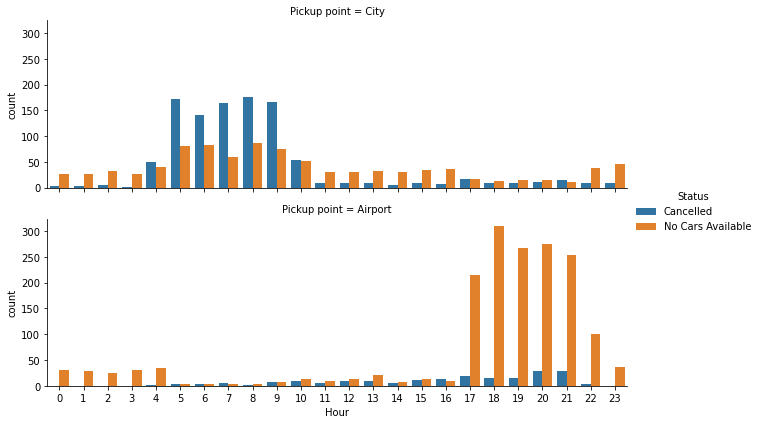

In [89]:
# Using factorplot since we have to visualize the spread of count of trips broken down by status of trip and pickup point
# plot hour w.r.t. status for different pickup points and identify the most pressing problems for Uber; Incomplete trips only
sns.factorplot(x = "Hour", hue = "Status", row = "Pickup point", data = uber_data[uber_data['Status']!='Trip Completed'], kind = "count", size=3, aspect=3)

**Inference 1**: Uber is facing 'No Car Available' issue at Airport in evening and night (5pm to 12am)

**Inference 2**: Uber is facing cab 'Cancelled' issue in City during early morning and morning (4am to 10am)

**Inference 3**: Uber is facing 'No Car Available' issue in City during early morning and morning (4am to 10am)

---

### Checking if the problem is similar across all days

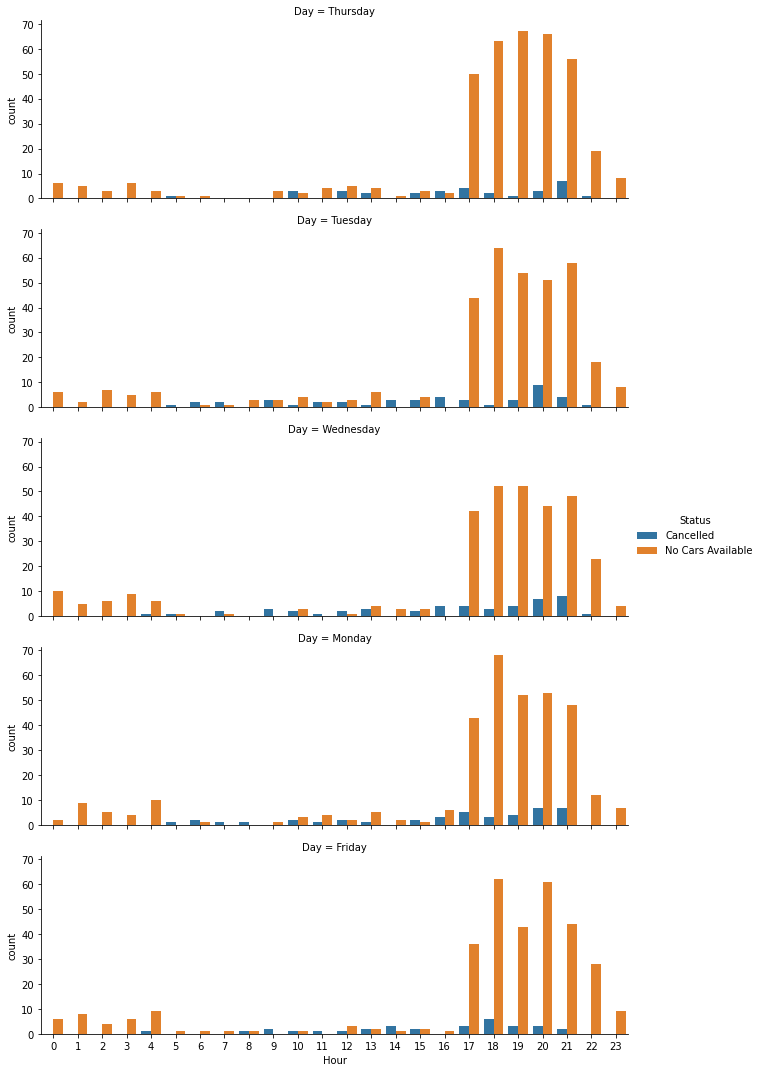

In [90]:
# Using factorplot since we have to visualize the spread of count of trips broken down by status of trip and day of week
# For pickup point Airport; Incomplete trips
# factor plot of hour and day of week w.r.t. status
sns.factorplot(x = "Hour", hue = "Status", row = "Day", data = uber_data[(uber_data['Pickup point']=="Airport")&(uber_data['Status']!='Trip Completed')], kind = "count", size=3, aspect=3)

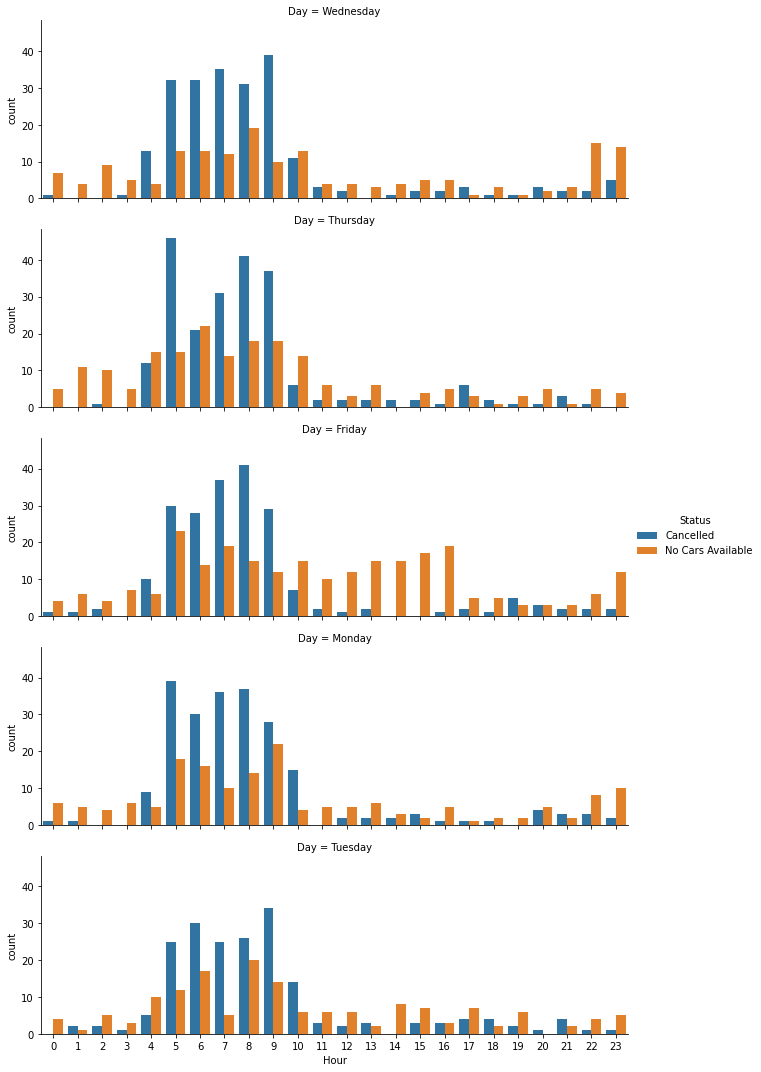

In [91]:
# Using factorplot since we have to visualize the spread of count of trips broken down by status of trip and day of week
# For pickup point City; Incomplete trips
# factor plot of hour and day of week w.r.t. status
sns.factorplot(x = "Hour", hue = "Status", row = "Day", data = uber_data[(uber_data['Pickup point']=="City")&(uber_data['Status']!='Trip Completed')], kind = "count", size=3, aspect=3)

**Inference 4**: Uber is facing similar problem across all days of week 

---

### Finding out the gap between supply and demand and show the same using plots.

In [92]:
# Computing overall Demand-Supply gap
# Count of Total Trip Requested
print('Count of Total Trip Requested')
total_trip_count = uber_data['Request id'].count()
print(total_trip_count)
# Count of Completed Trip
print('Count of Completed Trip')
print(uber_data[uber_data['Status']=='Trip Completed']['Request id'].count())
# Percent of Completed Trip
print('Percent of Completed Trip')
print(round(100*uber_data[uber_data['Status']=='Trip Completed']['Request id'].count()/total_trip_count),2)
# Count of Trip that did not happened
print('Count of Trip that did not happened')
print(uber_data[uber_data['Status']!='Trip Completed']['Request id'].count())
# Percent of Trip that did not happened
print('Percent of Trip that did not happened')
print(round(100*uber_data[uber_data['Status']!='Trip Completed']['Request id'].count()/total_trip_count),2)

Count of Total Trip Requested
6745
Count of Completed Trip
2831
Percent of Completed Trip
42 2
Count of Trip that did not happened
3914
Percent of Trip that did not happened
58 2


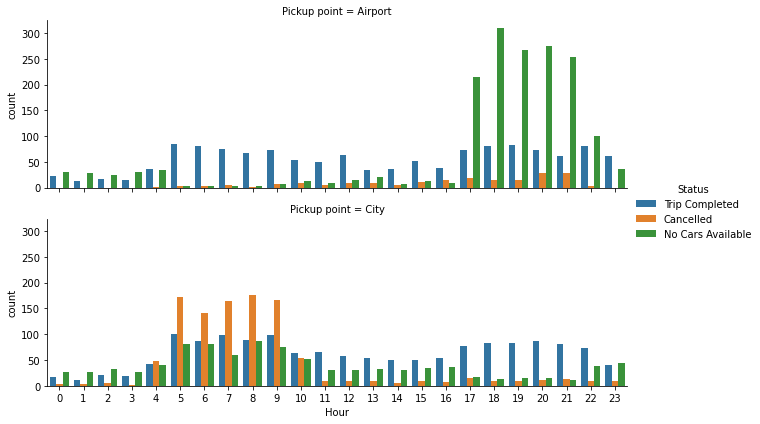

In [93]:
# Using factorplot since we have to visualize the spread of count of trips broken down by status of trip and pickup point
# factor plot of hour w.r.t. status for different pickup points; All trips
sns.factorplot(x = "Hour", hue = "Status", row = "Pickup point", data = uber_data, kind = "count", size=3, aspect=3)

**Inference 5**: At Airport, demand is higher than supply during evening and night (5pm to 12am)

**Inference 6**: In City, demand is greater than supply during early morning and morning (4am to 10am)

In [94]:
# Function to create pie chart for demand-supply
def pie_chart(dataframe, title):
    """
    creates a pie chart
    input: dataframe with a 'category' as index and a numerical column, title for pie chart
    output: pie chart
    """
    labels = dataframe.index.values
    sizes = dataframe['Status'].values
    
    fig1, ax = plt.subplots()
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
    ax.axis('equal')
    ax.set_title(title)
    plt.show()

#### Visualizing Inference 5 (Only 24.7% demands were fulfilled) during evening and night (5pm to 12am)

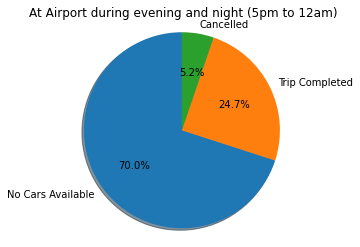

In [95]:
# Using pie chart since we have to visualize composition
# Visualizing supply-demand at Airport during evening and night (5pm to 12am)
df_airport_count = pd.DataFrame(
    uber_data[(uber_data['Pickup point']=='Airport')&((uber_data['Slot']=="Evening")|(uber_data['Slot']=="Night"))]
    .Status.value_counts())
pie_chart(df_airport_count, "At Airport during evening and night (5pm to 12am)")

#### Visualizing Inference 6 (Only 30.9% demands were fulfilled) during evening and night (5pm to 12am)

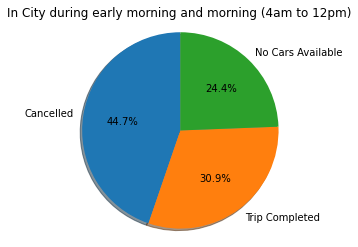

In [96]:
# Using pie chart since we have to visualize composition
# Visualizing supply-demand in City during early morning and morning (4am to 12pm)
df_airport_count = pd.DataFrame(
    uber_data[(uber_data['Pickup point']=='City')&((uber_data['Slot']=="Early Morning")|(uber_data['Slot']=="Morning"))]
    .Status.value_counts())
pie_chart(df_airport_count, "In City during early morning and morning (4am to 12pm)")

---

## Analysing Issue

### Univariate and Segmented analysis

<AxesSubplot:>

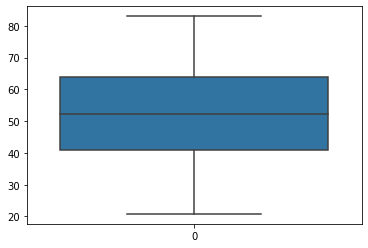

In [97]:
# Using Box plot since we have to visualize variation in one field
# Box plot for univariate analysis of 'Duration' field
sns.boxplot(data=uber_data[(uber_data['Duration']>0)]['Duration'])

<AxesSubplot:xlabel='Hour', ylabel='Duration'>

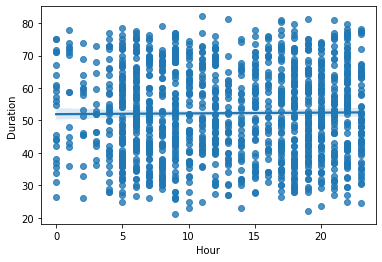

In [98]:
# For Airport to City rides
# Using scatterplot (regplot) since we have to visualize corelation, if any.
# scatter plot of hour w.r.t. Duration
sns.regplot(x = "Hour", y = "Duration", data = uber_data[(uber_data['Duration']>0)&(uber_data['Pickup point']=='Airport')])

<AxesSubplot:xlabel='Hour', ylabel='Duration'>

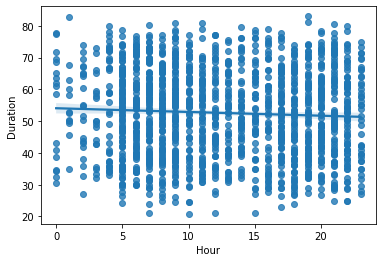

In [99]:
# For City to Airport rides
# Using scatterplot (regplot) since we have to visualize corelation, if any.
# scatter plot of hour w.r.t. Duration
sns.regplot(x = "Hour", y = "Duration", data = uber_data[(uber_data['Duration']>0)&(uber_data['Pickup point']=='City')])

**Inference 1**: Ride durations does not vary much for various slots and for various rides (airport to city) or (city to airport), thus traffic conjession is not an issue causing factor.

### Checking if driver wait time at airport is an issue causing factor

#### Calculating driver wait time at airport

In [100]:
# Making a copy of original dataframe
wait_ud = uber_data.copy()
# Dropping rows with no driver id since those cannot be used for this analysis
wait_ud['Driver id'].dropna()
# Sorting data accordingly for next calculation
wait_ud = wait_ud[wait_ud['Status']=='Trip Completed'].sort_values(by=['Driver id','Request timestamp'])
# Computing wait duration by calculating difference of current Request Timestamp and previous Drop Timestamp
wait_ud['Wait Duration'] = wait_ud['Request timestamp']-wait_ud['Drop timestamp'].shift()
# Canverting wait duration to munutes
wait_ud['Wait Duration'] = round(wait_ud['Wait Duration'].dt.total_seconds()/60,1)
# Dropping rows where wait duration could not be computed
wait_ud['Wait Duration'].dropna()
# Removing the first trip for each driver since wait time for that can not be calculated
wait_ud = wait_ud[wait_ud['Wait Duration']>0]
# We are only interested in calculating wait time for the rides that actually took place
wait_ud = wait_ud[wait_ud['Status']=='Trip Completed']

wait_ud.head()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp,Duration,Slot,Hour,Day,Wait Duration
1,867,Airport,1.0,Trip Completed,2016-07-11 17:57:00,2016-07-11 18:47:00,50.0,Evening,17,Monday,297.0
2,1807,City,1.0,Trip Completed,2016-07-12 09:17:00,2016-07-12 09:58:00,41.0,Morning,9,Tuesday,870.0
3,2532,Airport,1.0,Trip Completed,2016-07-12 21:08:00,2016-07-12 22:03:00,55.0,Night,21,Tuesday,670.0
4,3112,City,1.0,Trip Completed,2016-07-13 08:33:16,2016-07-13 09:25:47,52.5,Morning,8,Wednesday,630.3
5,3879,Airport,1.0,Trip Completed,2016-07-13 21:57:28,2016-07-13 22:28:59,31.5,Night,21,Wednesday,751.7


In [101]:
# Univariate analysis for 'Wait Duration' field
wait_ud['Wait Duration'].describe()

count    2531.000000
mean      646.388779
std       543.267221
min         2.000000
25%       247.350000
50%       508.300000
75%       862.950000
max      4794.400000
Name: Wait Duration, dtype: float64

<AxesSubplot:xlabel='Hour', ylabel='Wait Duration'>

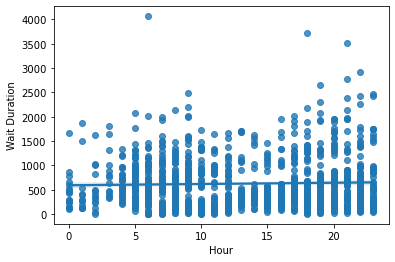

In [102]:
# Wait time at Airport
# Using scatterplot (regplot) since we have to visualize corelation, if any.
# scatter plot of hour w.r.t. Wait Duration 
sns.regplot(x = "Hour", y = "Wait Duration", data = wait_ud[wait_ud['Pickup point']=='Airport'])

**Inference 2**: Wait time for next rides from airport is comparatively high during 5am to 9am. The same is seen during 7pm to 11pm. 

**Problem Summary**: 
* We have comparatively high wait time at Airport during early-morning, morning and also during evening, night.
* Cab drivers may not prefer to take bookings in city and travel instead of taking booking for airport and keep waiting there.
* Thus, Driver Wait Duration could be causing problems faced by Uber.


**Solution Summary**:
* For addressing early morning and morning 'Cancelled' rides
    * Penalty for driver cancelling Airport booking thrice a day
    * Provide incentive to drivers for Airport Rides / Airport Wait Duration
* For addressing 'No Car Available' issue at Airport in evening and night
    * Airport Rides can be given weightage of 1.5 ride count
    * Exempt drivers with Airport Rides from daily minimum rides 
* For addressing ‘No Car Available' issue in City during early morning and morning
    * Provide incentive to drivers for Airport Rides / Airport Wait Duration
